In [2]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [4]:
EPSILON_START = 0.5
EPSILON_END = 0
EPSILON_DECAY = 40000

gamma = 0.9
alpha = 0.1

In [6]:
import numpy as np
from collections import defaultdict

starting_pos = (3,0)
state = defaultdict(lambda : 0)

for i in range(4):
    for j in range(12):
        if i == 3 and j>= 1 and j<11:
            state[(i,j)] = -1
        elif i == 3 and j == 11:
            state[(i,j)] = 1
        else:
            state[(i,j)] = 0
            
actions = ["up", "down", "left", "right"]


In [8]:
visualization = np.array(list(state.items()))
visualization = np.reshape(visualization, (4, 24))

BOARD = np.zeros((4,12))

print("================== CURRENT BOARD ==================")
for i in range(4):
    for j in range(12):
        if visualization[i][2*j + 1] == 0:
            BOARD[i][j] = 0
        elif visualization[i][2*j + 1] == 1:
            BOARD[i][j] = 1
        else:
            BOARD[i][j] = -1

print(BOARD)

================== CURRENT BOARD ==================
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.]]


/home/soohyoen/anaconda3/envs/rein_study/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [9]:
def NextState(current_pos, action):
    
    origin = current_pos
    nxt_state_row = current_pos[0]
    nxt_state_col = current_pos[1]
    
    if action == 'up':
        nxt_state_row -= 1
    elif action == 'down':
        nxt_state_row += 1
    elif action == 'left':
        nxt_state_col -= 1
    elif action == 'right':
        nxt_state_col += 1
        
    if nxt_state_row >= 0 and nxt_state_row <= 3:
        if nxt_state_col >= 0 and nxt_state_col <= 11:
            # 움직였을 때 제대로 보드안에 들어온 경우(Cliff or Goal or 일반적인 state)
            return (nxt_state_row, nxt_state_col)
        else:
            # 움직였을때 보드안에 들어온 경우에는 현재 포지션을 그래도 유지시킴
            return origin
    else:
        return origin

In [10]:
# reward function
# 만약 state의 값이 -1이 였다면

def reward(pos):
    if state[pos] == -1:
        return -100
    elif state[pos] == 1:
        return 10
    else:
        return -1

In [11]:
# Q table과 정책의 정의
Q_table_SARSA = defaultdict(lambda : 0)
pi_table_SARSA = defaultdict(lambda : 0)
Q_table_Q_learning = defaultdict(lambda : 0)
pi_table_Q_learning = defaultdict(lambda : 0)

# 각 에피소드의 reward가 reward_sum_list_SARSA 와 rewad_sum_list_Q_learning에 담기게 된다.
reward_sum_list_SARSA = []
reward_sum_list_Q_learning = []

In [12]:
def ChooseAction(current_pos, Q_table, epsilon):
    
    # 내가 뽑은 난수가 epsilon보다 작다면(or같다면) random한 action을 해준다.
    if np.random.uniform(0,1) <= epsilon:
        return np.random.choice(actions)
    
    # 내가 뽑은 난수가 epsilon보다 크다면 greedy action을 해준다.
    else:
        Q_up = Q_table[(current_pos,'up')]
        Q_down = Q_table[(current_pos,'down')]
        Q_left = Q_table[(current_pos,'left')]
        Q_right = Q_table[(current_pos,'right')]
        
        QList = [Q_up, Q_down, Q_left, Q_right]
        
        # argmax
        
        return actions[np.argmax(QList)]

In [13]:
# SARSA control
def play_episode_SARSA(starting_pos, epsil):
    rewardList_SARSA = []
    current_state = starting_pos
    action = ChooseAction(current_state, Q_table_SARSA, epsil)
    while True:

        next_state = NextState(current_state, action)
        r = reward(next_state)

        rewardList_SARSA.append(r)                                              # 이 에피소드에 대한 reward를 저장한다. 다음 에피소드에서는 새로운 rewardList_SARSA를 쓴다. 
        next_action = ChooseAction(next_state, Q_table_SARSA, epsil)

        # main SARSA algorithm
        Q_table_SARSA[current_state, action]  = (1 - alpha) * Q_table_SARSA[current_state, action] + alpha * (r + gamma * Q_table_SARSA[next_state, next_action])

        current_state = next_state
        action = next_action

        if (state[current_state] == 1 or state[current_state] == -1):             # end while loop when the agent reaches the goal or cliffs
            break

    reward_sum_list_SARSA.append(sum(rewardList_SARSA))

In [14]:
# Q-learning control
def play_episode_Qlearning(starting_pos, epsil):
    rewardList_Q_learning = []
    current_state = starting_pos
    while True:

        action = ChooseAction(current_state, Q_table_Q_learning, epsil)
        next_state = NextState(current_state, action)
        r = reward(next_state)

        rewardList_Q_learning.append(r)                                         # 이 에피소드에 대한 reward를 저장한다. 다음 에피소드에서는 새로운 rewardList_Q_learning를 쓴다. 
        optimal_action = ChooseAction(next_state, Q_table_Q_learning, 0)

        # main Q-Learning algorithm
        Q_table_Q_learning[current_state, action] = (1 - alpha) * Q_table_Q_learning[current_state, action] + alpha * (r + gamma*Q_table_Q_learning[next_state, optimal_action])

        current_state = next_state

        if (state[current_state] == 1 or state[current_state] == -1):             # end while loop when the agent reaches the goal or cliffs
            break

    reward_sum_list_Q_learning.append(sum(rewardList_Q_learning))

In [15]:

# play episode on SARSA control
count = 50000

for i in range(count):

    epsilon = np.interp(i, [0, EPSILON_DECAY], [EPSILON_START, EPSILON_END])    # epsilon value anneals from 0.5 to 0 

    play_episode_SARSA(starting_pos, epsilon)

In [16]:

# play episode on Q-learning control
for i in range(count):

    epsilon = np.interp(i, [0, EPSILON_DECAY], [EPSILON_START, EPSILON_END])    # epsilon value anneals from 0.5 to 0 

    play_episode_Qlearning(starting_pos, epsilon)

In [17]:
# pi_table_SARSA update 
for i in range(4):
    for j in range(12):
        Q_up = Q_table_SARSA[((i,j),'up')]
        Q_down = Q_table_SARSA[((i,j),'down')]
        Q_left = Q_table_SARSA[((i,j),'left')]
        Q_right = Q_table_SARSA[((i,j),'right')]

        QList = [Q_up,Q_down,Q_left,Q_right]
        pi_table_SARSA[(i,j)] = actions[np.argmax(QList)]                       # pi_table_SARSA[(i,j)]에는 'up', 'down', 'left', or 'right'값이 담긴다. 

# pi_table_Qlearning update 
for i in range(4):
    for j in range(12):
        Q_up = Q_table_Q_learning[((i,j),'up')]
        Q_down = Q_table_Q_learning[((i,j),'down')]
        Q_left = Q_table_Q_learning[((i,j),'left')]
        Q_right = Q_table_Q_learning[((i,j),'right')]
        
        QList = [Q_up,Q_down,Q_left,Q_right]
        pi_table_Q_learning[(i,j)] = actions[np.argmax(QList)]                  # pi_table_Q_learning[(i,j)]에는 'up', 'down', 'left', or

In [18]:
# SARSA
# 각 state의 policy를 보여준다. 

for i in range(4):
    print(f'{i}------------------------------------------------------------')
    out = '| '
    for j in range(12):
        if pi_table_SARSA[(i,j)] == 'up':
            token = '↑'
        if pi_table_SARSA[(i,j)] == 'down':
            token = '↓'
        if pi_table_SARSA[(i,j)] == 'right':
            token = '→'
        if pi_table_SARSA[(i,j)] == 'left':
            token = '←'
        if state[(i,j)] == -1:
            token = '**'
        if (i, j) == (3,11):
            token = ' G'
        if (i, j) == (3, 0):
            token = 'S '
        out += token + ' | '
    print(out)
print('-------------------------------------------------------------')

0------------------------------------------------------------
| → | → | → | → | → | → | → | → | → | ↓ | → | ↓ | 
1------------------------------------------------------------
| ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | → | → | → | → | ↓ | 
2------------------------------------------------------------
| ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | ↑ | → | ↓ | 
3------------------------------------------------------------
| S  | ** | ** | ** | ** | ** | ** | ** | ** | ** | ** |  G | 
-------------------------------------------------------------


In [19]:
# Q-Learning
# 각 state의 policy를 보여준다. 

for i in range(4):
    print(f'{i}------------------------------------------------------------')
    out = '| '
    for j in range(12):
        if pi_table_Q_learning[(i,j)] == 'up':
            token = '↑'
        if pi_table_Q_learning[(i,j)] == 'down':
            token = '↓'
        if pi_table_Q_learning[(i,j)] == 'right':
            token = '→'
        if pi_table_Q_learning[(i,j)] == 'left':
            token = '←'
        if state[(i,j)] == -1:
            token = '**'
        if (i, j) == (3,11):
            token = ' G'
        if (i, j) == (3, 0):
            token = 'S '
        out += token + ' | '
    print(out)
print('-------------------------------------------------------------')

0------------------------------------------------------------
| → | ↓ | → | ↓ | ↓ | → | ↓ | ↓ | ↓ | ↓ | ↓ | ↓ | 
1------------------------------------------------------------
| ↓ | ↓ | → | ↓ | ↓ | → | ↓ | ↓ | ↓ | ↓ | ↓ | ↓ | 
2------------------------------------------------------------
| → | → | → | → | → | → | → | → | → | → | → | ↓ | 
3------------------------------------------------------------
| S  | ** | ** | ** | ** | ** | ** | ** | ** | ** | ** |  G | 
-------------------------------------------------------------


In [20]:

# Visualisation을 해주기 위해서 Cliff가 있는 곳에 reward=100, Goal이 있는 곳에 reward=1를 준다. 
# 위에 코드에서 Cliff or Goal statefmf 만나면 loop이 terminate되기 때문에, 이렇게 안해주면 Cliff의 값은 0으로 나온다.

for i in range(4):
    for j in range(12):
        if i == 3 and j >= 1 and j < 11:
            Q_table_SARSA[(i,j), 'up']    = -100
            Q_table_SARSA[(i,j), 'down']  = -100
            Q_table_SARSA[(i,j), 'right'] = -100
            Q_table_SARSA[(i,j), 'left']  = -100

            Q_table_Q_learning[(i,j), 'up']    = -100
            Q_table_Q_learning[(i,j), 'down']  = -100
            Q_table_Q_learning[(i,j), 'right'] = -100
            Q_table_Q_learning[(i,j), 'left']  = -100

        elif i == 3 and j == 11:
            Q_table_SARSA[(i,j), 'up']    = 10
            Q_table_SARSA[(i,j), 'down']  = 10
            Q_table_SARSA[(i,j), 'right'] = 10
            Q_table_SARSA[(i,j), 'left']  = 10

            Q_table_Q_learning[(i,j), 'up']    = 10
            Q_table_Q_learning[(i,j), 'down']  = 10
            Q_table_Q_learning[(i,j), 'right'] = 10
            Q_table_Q_learning[(i,j), 'left']  = 10

[]

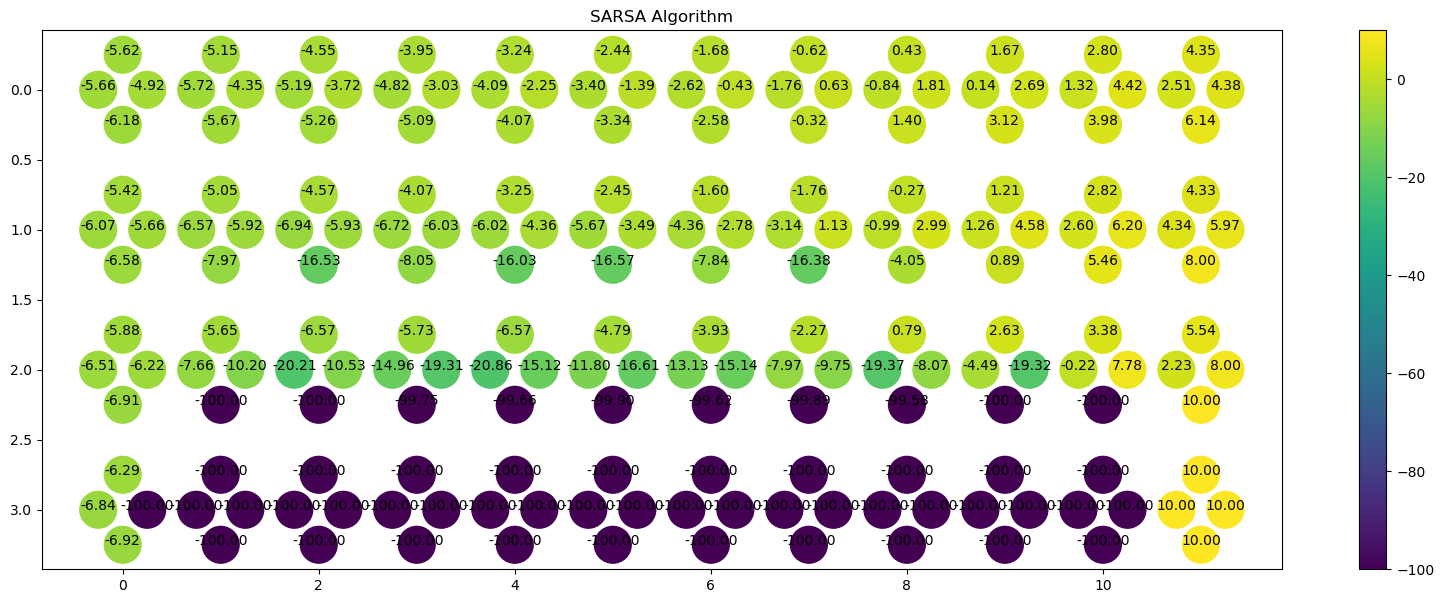

In [21]:
# Plot Q_table_SARSA

row_vals = []
col_vals = []
udlr   = []
vals   = []

for i in range(len(Q_table_SARSA)):
    row_vals.append(list(Q_table_SARSA.keys())[i][0][0])
    col_vals.append(list(Q_table_SARSA.keys())[i][0][1])
    udlr.append(list(Q_table_SARSA.keys())[i][1])
    vals.append(list(Q_table_SARSA.values())[i])

for i in range(len(Q_table_SARSA)):
    if udlr[i] == 'right':
        col_vals[i] = col_vals[i] + 0.25
    if udlr[i] == 'left':
        col_vals[i] = col_vals[i] - 0.25
    if udlr[i] == 'up':
        row_vals[i] = row_vals[i] - 0.25
    if udlr[i] == 'down':
        row_vals[i] = row_vals[i] + 0.25


plt.figure(figsize=(20, 7))
plt.title('SARSA Algorithm')
plt.scatter(col_vals, row_vals, s=700, c=vals)

for x, y, z in zip(col_vals, row_vals, vals):
    label = "{:.2f}".format(z)

    plt.annotate(label,             # this is the text
                (x,y),              # this is the point to label
                textcoords="offset points",     # how to position the text
                xytext=(0,0),       # distance from text to points (x,y)
                ha='center')        # horizontal alignment can be left, right or center

plt.gca().invert_yaxis()
plt.colorbar()
plt.plot()

[]

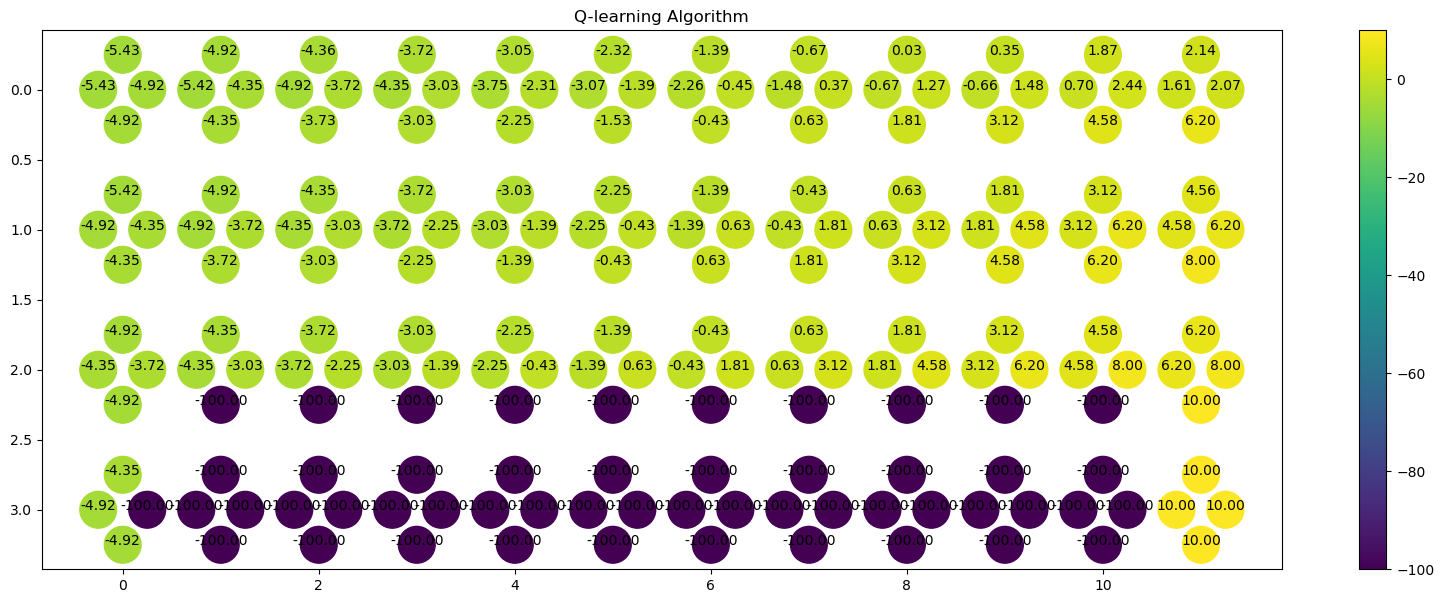

In [22]:
# Plot Q_table_Q_learning

row_vals = []
col_vals = []
udlr   = []
vals   = []

for i in range(len(Q_table_Q_learning)):
    row_vals.append(list(Q_table_Q_learning.keys())[i][0][0])
    col_vals.append(list(Q_table_Q_learning.keys())[i][0][1])
    udlr.append(list(Q_table_Q_learning.keys())[i][1])
    vals.append(list(Q_table_Q_learning.values())[i])

for i in range(len(Q_table_Q_learning)):
    if udlr[i] == 'right':
        col_vals[i] = col_vals[i] + 0.25
    if udlr[i] == 'left':
        col_vals[i] = col_vals[i] - 0.25
    if udlr[i] == 'up':
        row_vals[i] = row_vals[i] - 0.25
    if udlr[i] == 'down':
        row_vals[i] = row_vals[i] + 0.25


plt.figure(figsize=(20, 7))
plt.title('Q-learning Algorithm')
plt.scatter(col_vals, row_vals, s=700, c=vals)

for x, y, z in zip(col_vals, row_vals, vals):
    label = "{:.2f}".format(z)

    plt.annotate(label,             # this is the text
                (x,y),              # this is the point to label
                textcoords="offset points",     # how to position the text
                xytext=(0,0),       # distance from text to points (x,y)
                ha='center')        # horizontal alignment can be left, right or center

plt.gca().invert_yaxis()
plt.colorbar()
plt.plot()

[]

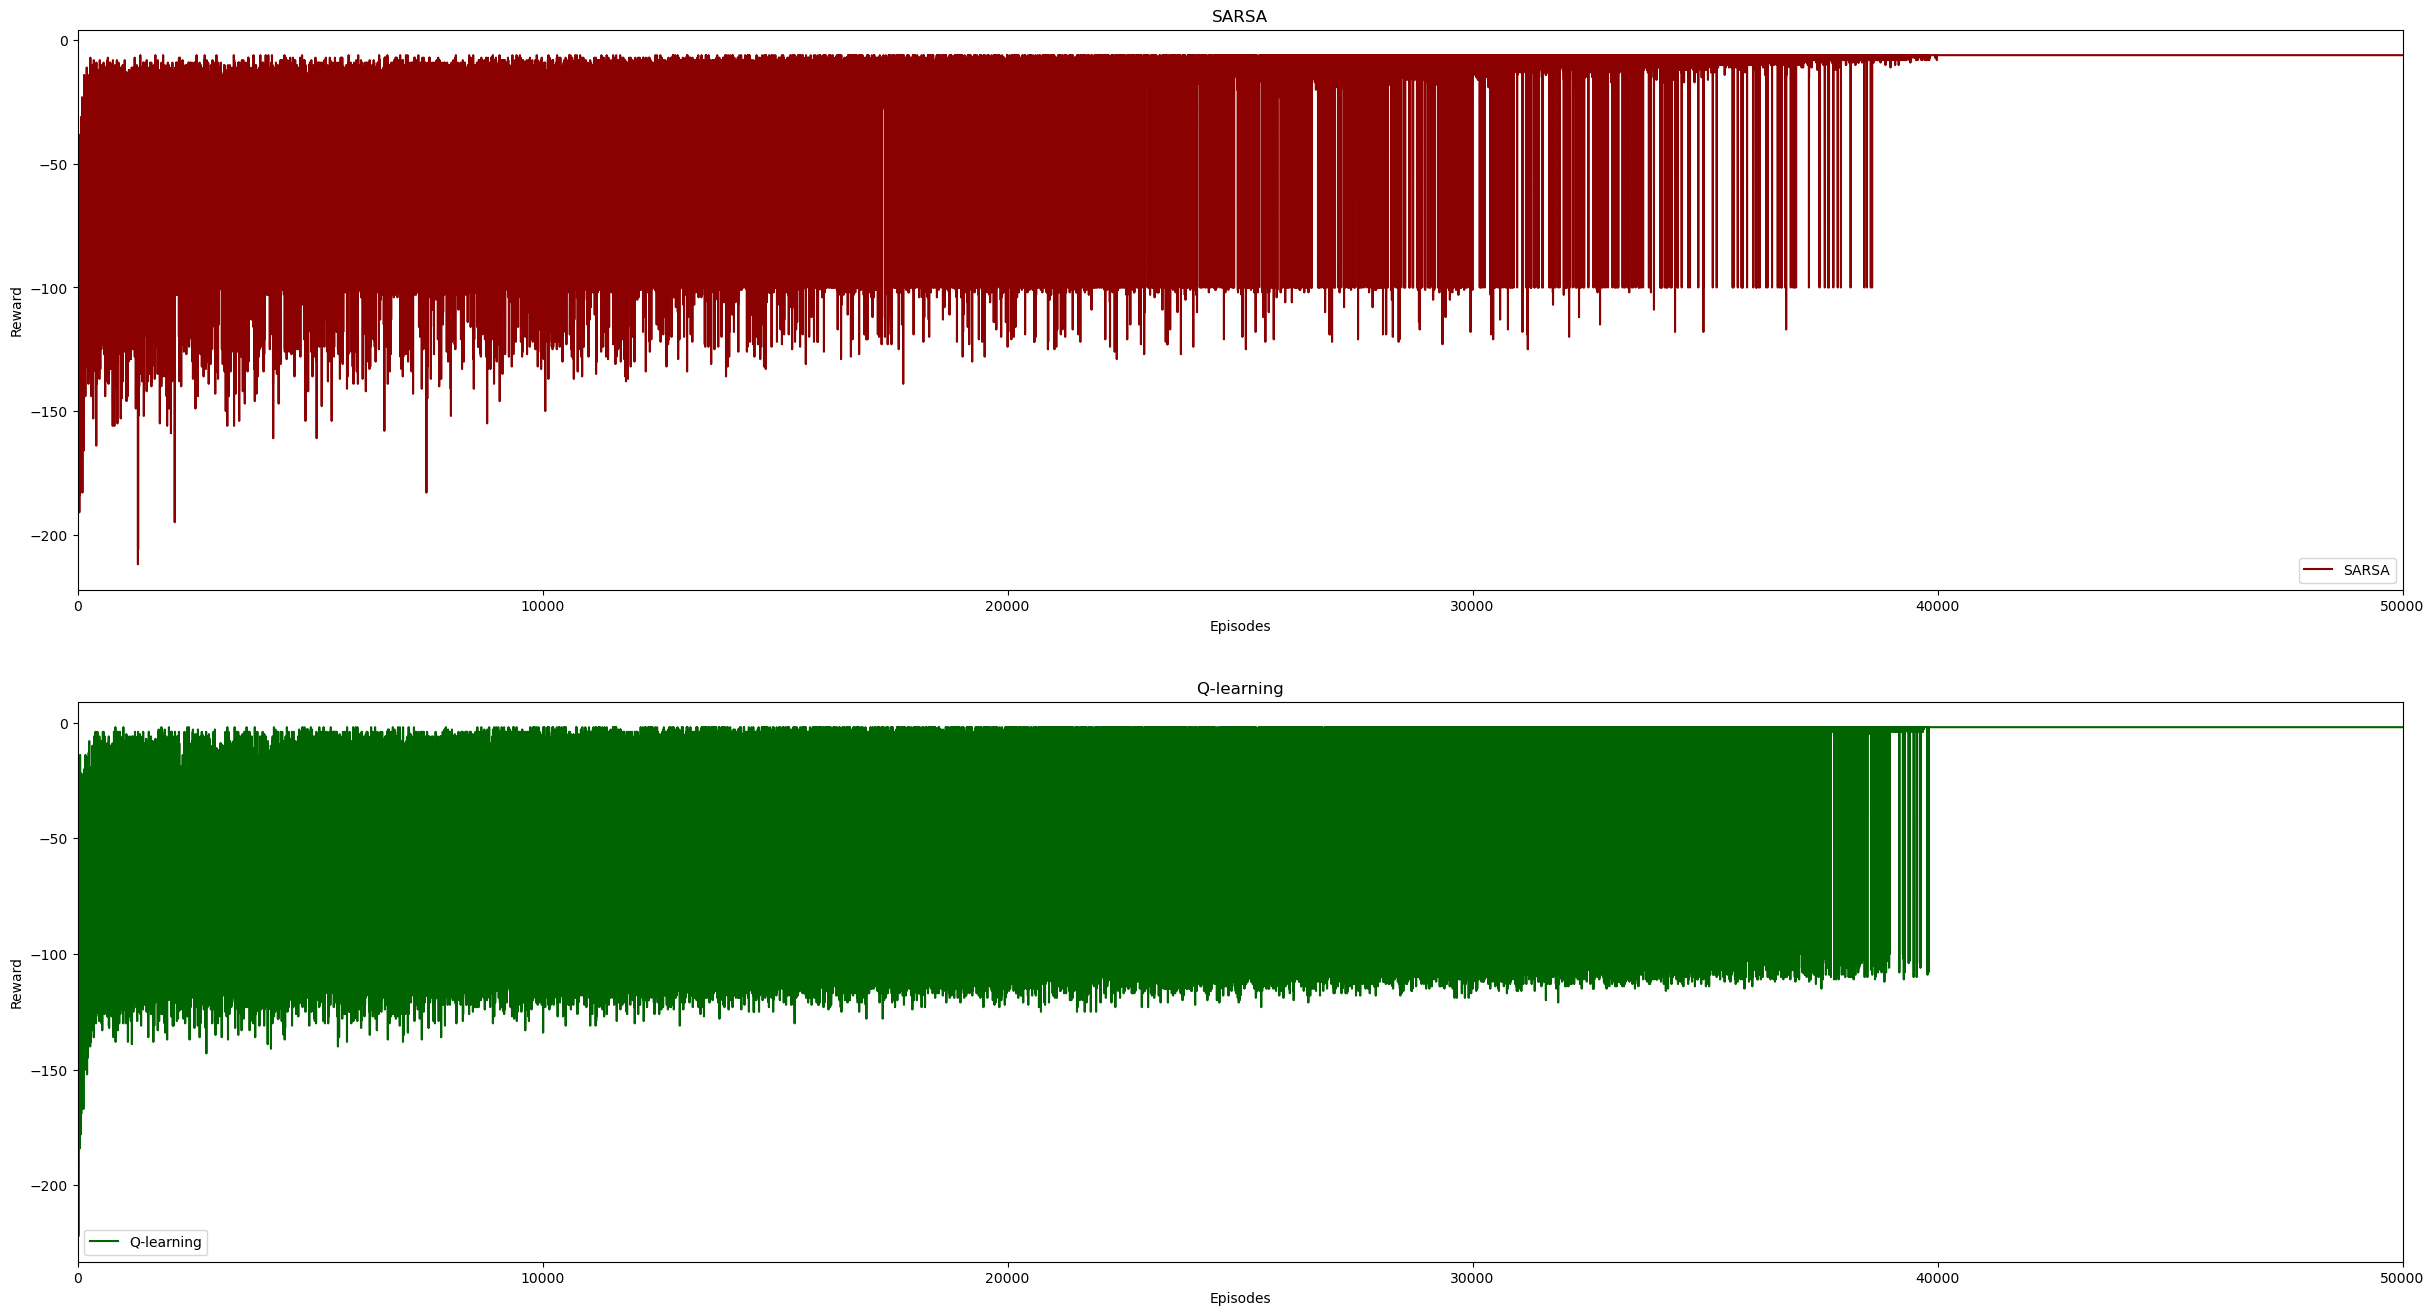

In [23]:
# Plot Reward table

import matplotlib.pyplot as plt

episode_count = []

for i in range(count):
    episode_count.append(i+1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 16))

ax1.plot(episode_count,reward_sum_list_SARSA, c='darkred', label='SARSA')
ax1.set_title("SARSA")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Reward")
ax1.set_xlim(0,50000)
ax1.legend()

ax2.plot(episode_count,reward_sum_list_Q_learning, c='darkgreen', label='Q-learning')
ax2.set_title("Q-learning")
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Reward")
ax2.set_xlim(0,50000)
ax2.legend()

plt.plot()